In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip -q install clu
    %load_ext tensorboard
    from google.colab import drive

    drive.mount("/content/drive")
    %cd '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers'
    import jax.tools.colab_tpu
    try:
        jax.tools.colab_tpu.setup_tpu()
    except RuntimeError:
        print("No TPU")

    # %tensorboard \
    # --logdir '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers/runs' \

In [2]:
import os
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import chain

import hephaestus_jax as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax import linen as nn
from flax import struct  # Flax dataclasses

from flax.training import train_state
from jax import random
from jax.config import config
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange

# config.update("jax_debug_nans", True)

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("../data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
dataset = hp.TabularDS(df, target_column="price")

In [4]:
mtm = hp.MTM(dataset, n_heads=4)
trm = hp.TRM(dataset, n_heads=4)

In [5]:
batch_size = 3
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = hp.mask_tensor(test_num, dataset)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = hp.mask_tensor(test_cat, dataset)

In [6]:
root_key = random.PRNGKey(0)
main_key, params_key, dropout_key = random.split(root_key, 3)

mtm_variables = mtm.init(
    params_key,
    test_cat_mask,
    test_num_mask,
)

trm_variables = trm.init(
    params_key,
    test_cat_mask,
    test_num_mask,
)

In [7]:
mtm_out = mtm.apply(
    {"params": mtm_variables["params"]},
    test_cat_mask,
    test_num_mask,
)
print(mtm_out[0].shape, mtm_out[1].shape)
mtm_out[0][0:2][0:2][0][0]

(3, 9, 33) (3, 6)


Array([ 0.01204084,  0.5344971 ,  0.04609842,  1.0744199 ,  0.30193168,
       -1.9273175 , -1.5839121 ,  0.04463059,  0.34511313,  0.39654085,
       -1.0900738 , -0.42682257,  0.27244532, -0.03933533,  0.04973991,
        1.168884  , -1.0068296 ,  0.85712874, -0.19324452, -0.8335487 ,
        1.0029398 ,  0.77957886, -0.90035725, -0.35409045,  0.7941923 ,
       -0.6628504 ,  1.0636376 , -1.3057976 , -1.563296  , -0.78487307,
        0.10405269,  0.5984377 , -1.6290282 ], dtype=float32)

In [8]:
regression_out = trm.apply(
    {"params": trm_variables["params"]},
    test_cat_mask,
    test_num_mask,
    # rngs={"dropout": jax.random.PRNGKey(43)}
)
regression_out

Array([[-0.6578226 , -0.46283603, -0.3883049 ,  0.02314657, -0.7864806 ,
        -0.4723398 ,  0.07804592,  0.31490204,  0.5385826 ],
       [-0.6528722 , -0.47174802, -0.17310399, -0.07970995, -0.73866093,
        -0.48131824, -0.03550117,  0.21402939,  0.5263754 ],
       [-0.2965283 ,  0.14984214,  0.5623148 ,  0.10470784, -0.13213792,
        -0.8856448 , -0.05423139,  0.01925551, -0.08705694]],      dtype=float32)

In [9]:
mi = hp.create_mi(dataset, 0, 3)
# print(mi)
mi.categorical_targets

Array([[13, 31, 16,  3,  7,  8, 10, 11, 12],
       [14, 24, 23,  3,  7,  8, 10, 11, 12],
       [17, 26, 21,  3,  7,  8, 10, 11, 12]], dtype=int32)

In [10]:
x = jnp.array([1.0, 2.0, 3.0, float("nan"), 5.0])
x = x.at[jnp.isnan(x)].set(10000)
x

Array([1.e+00, 2.e+00, 3.e+00, 1.e+04, 5.e+00], dtype=float32)

In [11]:
dataset.cat_mask_token

2

In [12]:
mi.numeric_mask

Array([[ 0.46847478,         nan, -0.65213853,         nan,         nan,
                nan],
       [        nan,  0.31452784,  0.6904618 , -0.57156855, -0.60810024,
                nan],
       [ 3.0000837 ,         nan, -1.099672  ,  1.8175548 ,  1.7559161 ,
         2.6941857 ]], dtype=float32)

In [13]:
def calculate_loss(
    params,
    mtm,
    mi: hp.ModelInputs,
):
    numeric_loss_scaler = 1
    logits, regression = mtm.apply(
        {"params": params},
        mi.categorical_mask,
        mi.numeric_mask,
    )
    categorical_loss = optax.softmax_cross_entropy_with_integer_labels(
        logits, mi.categorical_targets
    ).mean()
    numeric_loss = optax.squared_error(regression, mi.numeric_targets).mean()
    total_loss = categorical_loss + numeric_loss * numeric_loss_scaler

    return {
        "total_loss": total_loss,
        "categorical_loss": categorical_loss,
        "numeric_loss": numeric_loss,
    }


calculate_loss(mtm_variables["params"], mtm, mi)

{'total_loss': Array(7.8372808, dtype=float32),
 'categorical_loss': Array(3.862897, dtype=float32),
 'numeric_loss': Array(3.9743838, dtype=float32)}

In [14]:
def create_train_state(params_key, mi, lr=0.001, device=None):
    if device is None:
        device = jax.devices()[0]
    model = hp.MTM(dataset, d_model=64, n_heads=4)
    params = jax.device_put(
        model.init(
            params_key,
            mi.categorical_mask,
            mi.numeric_mask,
        )["params"],
        device,
    )
    tx = optax.adam(learning_rate=lr)

    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [15]:
@jax.jit
def train_step(state, mi):
    def loss_fn(params):
        return calculate_loss(params, mtm, mi)["total_loss"]

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss


@jax.jit
def eval_step(params, mi):
    return calculate_loss(params, mtm, mi)

In [16]:
state = create_train_state(params_key, mi)
res = hp.show_mask_pred(state.params, mtm, 0, dataset, probability=0.8, set="train")
pd.DataFrame.from_dict(res, orient="index")

,cut,color,clarity,carat,depth,table,x,y,z
masked,[MASK],[MASK],VVS2,NaN,0.174922,-0.652139,0.667566,0.608930,0.653636
actual,Ideal,D,VVS2,0.468475,0.174922,-0.652139,0.667566,0.608930,0.653636
pred,H,[NUMERIC_MASK],Fair,-0.005958,0.546422,0.331130,-1.053418,-1.064195,-0.218883


In [17]:
epochs = 300
total_loss = []
categorical_loss = []
numeric_loss = []
summary_writer = SummaryWriter(
    "runs/" + dt.now().strftime("%Y-%m:%dT%H:%M:%S") + "_mtm"
)

test_mi = hp.create_mi(dataset, set="test")

mi = hp.create_mi(dataset)
pbar = trange(epochs)
for epoch in pbar:
    state, loss = train_step(state, mi)
    train_loss_dict = eval_step(state.params, mi)

    total_loss.append(train_loss_dict["total_loss"].item())
    categorical_loss.append(train_loss_dict["categorical_loss"].item())
    numeric_loss.append(train_loss_dict["numeric_loss"].item())
    # Train Loss
    summary_writer.add_scalar(
        "TrainLoss/total", np.array(train_loss_dict["total_loss"].item()), epoch
    )
    summary_writer.add_scalar(
        "TrainLoss/categorical",
        np.array(train_loss_dict["categorical_loss"].item()),
        epoch,
    )
    summary_writer.add_scalar(
        "TrainLoss/numeric", np.array(train_loss_dict["numeric_loss"].item()), epoch
    )
    # Test Loss
    if epoch % 10 == 0:
        test_loss_dict = eval_step(state.params, test_mi)
        summary_writer.add_scalar(
            "TestLoss/total", np.array(test_loss_dict["total_loss"].item()), epoch
        )
        summary_writer.add_scalar(
            "TestLoss/categorical",
            np.array(test_loss_dict["categorical_loss"].item()),
            epoch,
        )
        summary_writer.add_scalar(
            "TestLoss/numeric", np.array(test_loss_dict["numeric_loss"].item()), epoch
        )
    pbar.set_description(f"Train Loss: {train_loss_dict['total_loss'].item():.4f}")
    # all_losses.append(loss.item())
    # logger.add_scalar("Loss/train", loss.item(), i)

total_loss = jnp.array(total_loss)
categorical_loss = jnp.array(categorical_loss)
numeric_loss = jnp.array(numeric_loss)  # A100: 14.00it/s V100: 8.71it/s T4: 2.70it/s

  0%|          | 0/300 [00:00<?, ?it/s]

(0.0, 4.0)

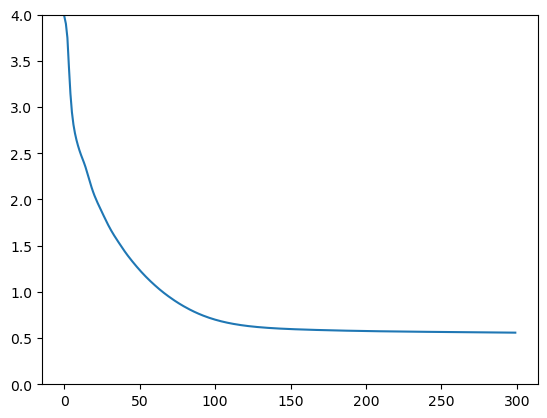

In [ ]:
# plot all_losses
sns.lineplot(categorical_loss)
plt.ylim(0, 4)

In [ ]:
categorical_loss.min()

Array(0.5586878, dtype=float32)

In [ ]:
res = hp.show_mask_pred(state.params, mtm, 0, dataset, probability=0.8, set="train")
pd.DataFrame.from_dict(res, orient="index")

,cut,color,clarity,carat,depth,table,x,y,z
masked,Ideal,[MASK],VS1,0.848216,0.384331,-1.547205,0.935006,0.985422,1.007898
actual,Ideal,H,VS1,0.848216,0.384331,-1.547205,0.935006,0.985422,1.007898
pred,Ideal,G,SI1,-0.044976,-0.003216,-0.032470,-0.048638,-0.043543,-0.040064


(0.0, 4.0)

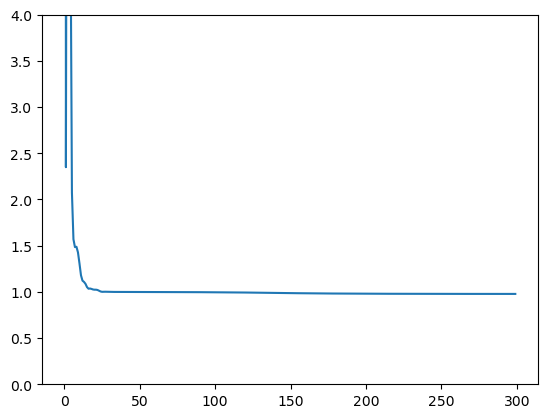

In [ ]:
sns.lineplot(numeric_loss)
plt.ylim(0, 4)

<Axes: >

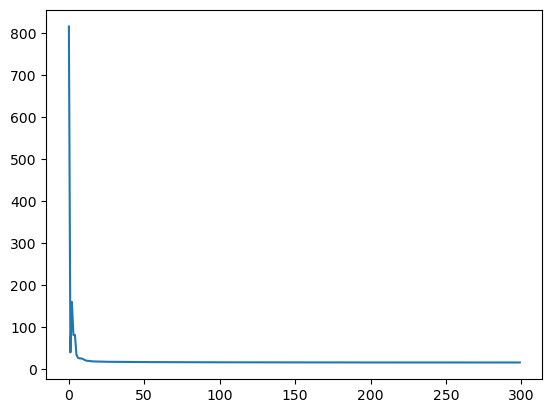

In [ ]:
# set max y to 10

sns.lineplot(total_loss)  # set max y to 10
# plt.ylim(0, 4)

In [ ]:
total_loss.min()

Array(15.227127, dtype=float32)

In [ ]:
# create random jnp array
# Set a random seed
key = jax.random.PRNGKey(0)

# Generate a random array with shape (3, 3)
random_array = jax.random.uniform(key, shape=(2, 6, 64))

In [ ]:
ra2 = jax.device_put(random_array)

In [ ]:
x = jnp.argmax(random_array, axis=-1)

In [ ]:
x[:, 0:-3].tolist()

[[38, 38, 36], [19, 52, 29]]

In [ ]:
key = jax.random.PRNGKey(0)

q = jax.random.uniform(key, shape=(2, 6, 64))
k = jax.random.uniform(key, shape=(2, 6, 64))
v = jax.random.uniform(key, shape=(2, 6, 64))

x = jnp.matmul(q, k.transpose((0, 2, 1)))

In [ ]:
nn.softmax(x, axis=-1)

Array([[[9.62481439e-01, 1.79157723e-02, 2.14223913e-03, 1.13957969e-03,
         1.39310118e-02, 2.38998164e-03],
        [1.94770552e-03, 9.92010713e-01, 1.16696791e-03, 1.64001598e-04,
         3.71223246e-03, 9.98497591e-04],
        [1.62648840e-03, 8.14993493e-03, 9.77109373e-01, 5.15797117e-04,
         1.17954873e-02, 8.02901981e-04],
        [5.44325486e-02, 7.20566884e-02, 3.24496366e-02, 6.95535600e-01,
         1.38041168e-01, 7.48446444e-03],
        [1.64415501e-03, 4.02999204e-03, 1.83353689e-03, 3.41076840e-04,
         9.91646111e-01, 5.05163160e-04],
        [1.10327099e-02, 4.23984230e-02, 4.88166930e-03, 7.23329897e-04,
         1.97589435e-02, 9.21204925e-01]],

       [[9.79415119e-01, 8.26539472e-04, 8.86300672e-03, 4.64231800e-03,
         1.10176217e-03, 5.15119731e-03],
        [1.67340937e-03, 9.68550146e-01, 4.98148147e-03, 2.40332237e-03,
         1.55431498e-02, 6.84854481e-03],
        [5.32317273e-02, 1.47777861e-02, 9.10479069e-01, 1.49047095e-03,
     